# Integration with Python

This cookbook explains you how to perform azimuthal integration using the python interpreter.
It is divided in two parts, the first part uses purely python while the second will use some advanced feature of the Jupyter notebook.

We will re-use the same files as is the other tutorials.

## Performing azimuthal integration with pyFAI of a bunch of images

To be able to perform the azimuthal integration of some images, one needs:

* The diffraction images themselves, in this example they are stored as TIFF files
* The geometry of the experimental setup as obtained from the calibration and stored as a PONI-file
* other files like flat-field, dark current images or detector distortion file (spline-fle).

Image file: http://www.silx.org/pub/pyFAI/cookbook/calibration/LaB6_29.4keV.tif

Detector distortion file: http://www.silx.org/pub/pyFAI/cookbook/calibration/F_K4320T_Cam43_30012013_distorsion.spline

The calibration has been performed in the previous cookbook. The geometry is saved in "LaB6_29.4keV.poni".

### Basic usage of pyFAI
To perform azimuthal averaging, one can use the pyFAI and FabIO libraries, the former to load the geometry and later to read the image:

In [1]:
# This cell is just to download the files to perform the analysis:
from silx.resources import ExternalResources
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/cookbook/calibration/", "PYFAI_DATA")
image_file = downloader.getfile("LaB6_29.4keV.tif")
spline_file = downloader.getfile("F_K4320T_Cam43_30012013_distorsion.spline")
poni_file = downloader.getfile("LaB6_29.4keV.poni")

print("image_file:", image_file)
print("poni_file:", poni_file)
print("spline_file:", spline_file)

# Copy all files locally
import shutil, os
shutil.copy(spline_file, ".")
shutil.copy(poni_file, ".")
shutil.copy(image_file, ".")
os.listdir()

image_file: /tmp/pyFAI_testdata_kieffer/LaB6_29.4keV.tif
poni_file: /tmp/pyFAI_testdata_kieffer/LaB6_29.4keV.poni
spline_file: /tmp/pyFAI_testdata_kieffer/F_K4320T_Cam43_30012013_distorsion.spline


['calib-gui',
 'LaB6_29.4keV.dat',
 'integration_with_scripts.ipynb',
 'index.rst',
 'LaB6_29.4keV.tif',
 'integration_with_the_gui.rst',
 '.ipynb_checkpoints',
 'F_K4320T_Cam43_30012013_distorsion.spline',
 'LaB6_29.4keV.poni',
 'pyFAI-integrate.png',
 'calib-cli',
 'integration_with_python.ipynb',
 'integrated.edf',
 'integrated.dat']

In [2]:
import pyFAI, fabio
print("pyFAI version:", pyFAI.version)
img = fabio.open("LaB6_29.4keV.tif")
print("image:", img)

ai = pyFAI.load("LaB6_29.4keV.poni")
print("\nIntegrator: \n", ai)

pyFAI version: 0.18.0
image: <fabio.edfimage.EdfImage object at 0x7f2d30b5ef98>

Integrator: 
 Detector Detector	 Spline= /mntdirect/_scisoft/users/kieffer/release/pyFAI/doc/source/usage/cookbook/F_K4320T_Cam43_30012013_distorsion.spline	 PixelSize= 5.168e-05, 5.126e-05 m
Wavelength= 4.217150e-11m
SampleDetDist= 1.181795e-01m	PONI= 5.396318e-02, 5.540257e-02m	rot1=0.006087  rot2= -0.008146  rot3= 0.000000 rad
DirectBeamDist= 118.186mm	Center: x=1066.678, y=1025.571 pix	Tilt=0.583 deg  tiltPlanRotation= -126.767 deg


### Azimuthal averaging using pyFAI


One needs first to retrieve the image as a numpy array. This allows to use other libraries than FabIO for image reading, for example HDF5.

This shows how to perform the azimuthal integration of one image over 1000 bins:


In [3]:
img_array = img.data
print("img_array:", type(img_array), img_array.shape, img_array.dtype)

res = ai.integrate1d(img_array, 
                     1000, 
                     unit="2th_deg", 
                     filename="integrated.dat")

img_array: <class 'numpy.ndarray'> (2048, 2048) float32


*Note:* There are 2 mandatory parameters for this method, the 2D-numpy array with the image and the number of bins. We specified in addition the name of the file, where to save the data and the unit for performing the integration.

There are many other options to integrate1d:

In [4]:
help(ai.integrate1d)

Help on method _integrate1d_legacy in module pyFAI.azimuthalIntegrator:

_integrate1d_legacy(data, npt, filename=None, correctSolidAngle=True, variance=None, error_model=None, radial_range=None, azimuth_range=None, mask=None, dummy=None, delta_dummy=None, polarization_factor=None, dark=None, flat=None, method='csr', unit=q_nm^-1, safe=True, normalization_factor=1.0, block_size=32, profile=False, all=False, metadata=None) method of pyFAI.azimuthalIntegrator.AzimuthalIntegrator instance
    Calculate the azimuthal integrated Saxs curve in q(nm^-1) by default
    
    Multi algorithm implementation (tries to be bullet proof), suitable for SAXS, WAXS, ... and much more
    
    
    
    :param data: 2D array from the Detector/CCD camera
    :type data: ndarray
    :param npt: number of points in the output pattern
    :type npt: int
    :param filename: output filename in 2/3 column ascii format
    :type filename: str
    :param correctSolidAngle: correct for solid angle of each pixel if

The result file contains the integrated data with some headers as shown:

In [5]:
with open("integrated.dat") as f:
    for i in range(50):
        print(f.readline().strip())

# == pyFAI calibration ==
# Distance Sample to Detector: 0.11817947569514631 m
# PONI: 5.396e-02, 5.540e-02 m
# Rotations: 0.006087 -0.008146 0.000000 rad
#
# == Fit2d calibration ==
# Distance Sample-beamCenter: 118.186 mm
# Center: x=1066.678, y=1025.571 pix
# Tilt: 0.583 deg  TiltPlanRot: -126.767 deg
#
# Detector Detector	 Spline= /mntdirect/_scisoft/users/kieffer/release/pyFAI/doc/source/usage/cookbook/F_K4320T_Cam43_30012013_distorsion.spline	 PixelSize= 5.168e-05, 5.126e-05 m
#    Detector has a mask: False
#    Detector has a dark current: False
#    detector has a flat field: False
#
# Wavelength: 4.2171495713063666e-11 m
# Mask applied: False
# Dark current applied: False
# Flat field applied: False
# Polarization factor: None
# Normalization factor: 1.0
# --> integrated.dat
#       2th_deg             I
1.668236e-02    2.742935e+00
5.004708e-02    2.763854e+00
8.341179e-02    2.027486e+00
1.167765e-01    2.828063e+00
1.501412e-01    2.858796e+00
1.835059e-01    2.676403e+00


### Azimuthal regrouping using pyFAI

This option is similar to the integration but perfroms N-integration on various azimuthal angle (chi) sections of the space. It is also named "caking" in Fit2D.

The azimuthal regrouping of an image over 500 radial bins in 360 angular steps (of 1 degree) can be performed like this:


In [6]:
res2 = ai.integrate2d(img_array, 
                      500, 360, 
                     unit="r_mm", 
                     filename="integrated.edf")

In [7]:
cake = fabio.open("integrated.edf")
print(cake.header)
print("cake:", type(cake.data), cake.data.shape, cake.data.dtype)


{
  "EDF_DataBlockID": "0.Image.Psd",
  "EDF_BinarySize": "720000",
  "EDF_HeaderSize": "1536",
  "ByteOrder": "LowByteFirst",
  "DataType": "FloatValue",
  "Dim_1": "500",
  "Dim_2": "360",
  "Image": "0",
  "HeaderID": "EH:000000:000000:000000",
  "Size": "720000",
  "Engine": "Detector Detector Spline= /mntdirect/_scisoft/users/kieffer/release/pyFAI/doc/source/usage/cookbook/F_K4320T_Cam43_30012013_distorsion.spline PixelSize= 5.168e-05, 5.126e-05 m Wavelength= 4.217150e-11m SampleDetDist= 1.181795e-01m PONI= 5.396318e-02, 5.540257e-02m rot1=0.006087 rot2= -0.008146 rot3= 0.000000 rad DirectBeamDist= 118.186mm Center: x=1066.678, y=1025.571 pix Tilt=0.583 deg tiltPlanRotation= -126.767 deg",
  "detector": "Detector",
  "pixel1": "5.1679e-05",
  "pixel2": "5.1265e-05",
  "max_shape": "(2048, 2048)",
  "splineFile": "/mntdirect/_scisoft/users/kieffer/release/pyFAI/doc/source/usage/cookbook/F_K4320T_Cam43_30012013_distorsion.spline",
  "dist": "0.11817947569514631",
  "poni1": "0.05396

From this it is trivial to perform a loop and integrate many images. 

*Attention:* The AzimuthalIntegrator object (called ai here) is rather large and costly to initialize. The best practice is to crate it once and to use it many times, like this:

In [8]:
import glob, os

all_images = glob.glob("LaB6*.tif")
ai = pyFAI.load("LaB6_29.4keV.poni")

for one_image in all_images:
    fimg = fabio.open(one_image)
    dest = os.path.splitext(one_image)[0] + ".dat"
    ai.integrate1d(fimg.data, 
                   1000, 
                   unit="2th_deg", 
                   filename=dest)

## Using some advanced feature of Jupyter Notebooks

Jupyter notebooks offer some advanced visualization features, especially when used with *matplotlib* and *pyFAI*.
Unfortunately, the example shown hereafter will not work properly in normal Python scipts.

### Initialization of the notebook for matplotlib integration:


In [9]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


/mntdirect/_scisoft/users/kieffer/.jupy37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
from pyFAI.gui import jupyter

In [11]:
### Visualzation of different types of results reviously calculated

<IPython.core.display.Javascript object>


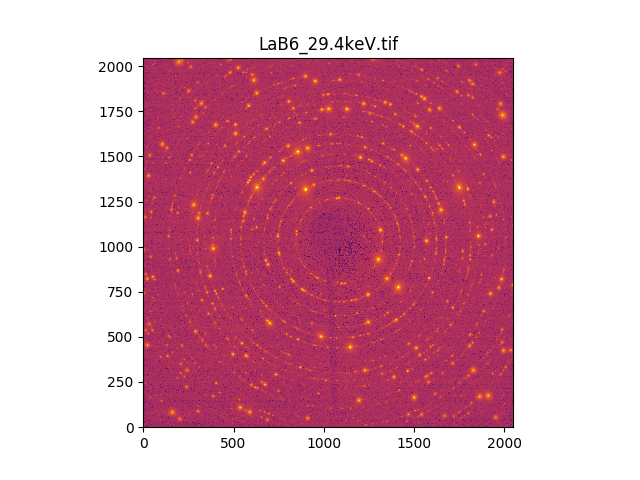

In [12]:
jupyter.display(img.data, label=img.filename)

<IPython.core.display.Javascript object>


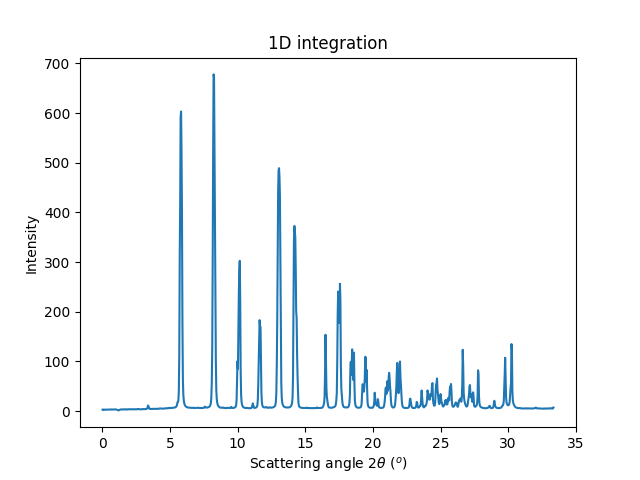

In [13]:
jupyter.plot1d(res)

<IPython.core.display.Javascript object>


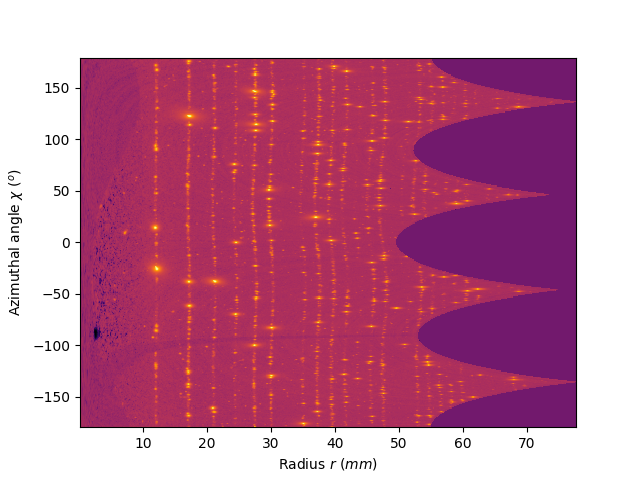

In [14]:
jupyter.plot2d(res2)

### Side note.
If you have tried to reproduce this, you may have noticed a couple of unconstiencies: 

* The image is called "tif" while the content is an "edf".
* The caked image has wavy lines meaning the calibration is far from perfect.

The first issue maybe corrected in uploading a properly converted image. 
The second issue is related to the spline file provided which was wrong (actually it is flipped up-down)

## Conclusion

This cookbook exapline the basic usage of pyFAI as a Python library for azimuthal integration and simple visualization in the Jupyter notebook.